## Decay Rates

In [1]:
cd '/home/dpirvu/project/paper_prefactor/'

/home/dpirvu/project/paper_prefactor


In [2]:
import os,sys
sys.path.append('/home/dpirvu/python_stuff/')
sys.path.append('/home/dpirvu/project/paper_prefactor/bubble_codes/')
#sys.path.append('/home/dpirvu/project/paper_prefactor/bubble_codes_older/')
#sys.path.remove('/home/dpirvu/DarkPhotonxunWISE/hmvec-master')
print(sys.path)
from plotting import *
from bubble_tools import *
from experiment import *
from celluloid import Camera
from scipy.optimize import curve_fit

%matplotlib inline

['/home/dpirvu/project/paper_prefactor', '/cm/shared/apps/python/python37/lib/python37.zip', '/cm/shared/apps/python/python37/lib/python3.7', '/cm/shared/apps/python/python37/lib/python3.7/lib-dynload', '', '/home/dpirvu/.local/lib/python3.7/site-packages', '/home/dpirvu/DarkPhotonxunWISE/hmvec-master', '/cm/shared/apps/python/python37/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages/IPython/extensions', '/home/dpirvu/.ipython', '/home/dpirvu/python_stuff/', '/home/dpirvu/project/paper_prefactor/bubble_codes/']
['/home/dpirvu/project/paper_prefactor', '/cm/shared/apps/python/python37/lib/python37.zip', '/cm/shared/apps/python/python37/lib/python3.7', '/cm/shared/apps/python/python37/lib/python3.7/lib-dynload', '', '/home/dpirvu/.local/lib/python3.7/site-packages', '/home/dpirvu/DarkPhotonxunWISE/hmvec-master', '/cm/shared/apps/python/python37/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages/IPython/exte

In [3]:
case = 'minus'
general = get_general_model(case)
tempList, massq, right_Vmax, V, dV, Vinv, nTimeMAX, minSim, maxSim = general


In [12]:
bubbleList, velocitesList, temperatureList, instantonList, tmpList, fldcritList, decayTimes, decayedSims = [], [], [], [], [], [], [], []
for ii, tmp in enumerate([0,1,2]):
    maxSim = (1000 if tmp == 0 else 2000 if tmp==1 else 3000 if tmp==2 else 2000)
    nTimeMAX = (262144 if tmp!=1 else 131072)        
    temp, m2, sigmafld = get_model(*general, tmp)
    exp_params = [nLat, m2, temp]
    print('Experiment', exp_params)

    tmpList.append(tmp)

    temperatureList.append(temp)

    decay_times = np.load(decay_times_file(*exp_params, minSim, maxSim, nTimeMAX))
    decayedSims.append(np.load(sims_decayed_file(*exp_params, minSim, maxSim, nTimeMAX)))

    decayTimes.append(np.sort(decay_times[:,1]))
    instantonList.append(np.load(ansol_instanton_file(*exp_params)))

    try:
        bubbleList.append(np.load(average_file(*exp_params)))
        velocitesList.append(np.load(velocities_file(*exp_params)))
        fldcritList.append(np.load(critfield_file(*exp_params)))
    except:
        bubbleList.append([])
        velocitesList.append([])
        fldcritList.append([])
print(tmpList, temperatureList)

Experiment [2048, 0.8049999999999999, 0.13]
[2] [0.13]


In [13]:
critenergy = np.zeros(len(tmpList))
for ii, tmp in enumerate(tmpList):
    try:
        xls, fldslice, momslice = np.array(fldcritList)[ii]
        gradinst  = (np.roll(fldslice,-1) - fldslice)/dx
        critenergy[ii] = dx * np.sum(V(fldslice) + 0.5*gradinst**2., axis=0)
    except:
        critenergy[ii] = 4./3.
print('energy', critenergy)

instanton = np.array(instantonList)[0]
instanton = instanton[np.argmax(instanton)-len(xls)//2 : np.argmax(instanton)+len(xls)//2]
gradinst  = (np.roll(instanton,-1) - instanton)/dx
instantonenergy = dx * np.sum(V(instanton) + 0.5*gradinst**2., axis=0)
print('energy', instantonenergy)

energy [1.33333333]


NameError: name 'xls' is not defined

In [15]:
M = len(tmpList)
TempList = np.array(temperatureList)
nTimeMAXList = np.array([262144, 131072, 262144, 262144])

lenLatList = np.array([lenLat])
dxList = lenLatList/nLat

TimeOfSimList = nTimeMAXList[tmpList] * dxList
Times = np.array(decayTimes) * dxList

In [16]:
lenLat

80.0

In [17]:
dxList

array([0.0390625])

In [18]:
TimeOfSimList

array([10240.])

In [19]:
t_points = 10000
t_l = [None]*M

Psurv = np.zeros((M,t_points))
for j in range(M):
    t_l[j] = np.linspace(0, TimeOfSimList[j] - 0.1, t_points)
    for i in range(0,len(Times[j])):
        if Times[j][i] == 0:
            Times[j][i] = TimeOfSimList[j]
    Times[j].sort()

for j in range(M):
    for i in range(0,t_points):
        Psurv[j,i] = (Times[j] > t_l[j][i]).sum() / len(Times[j])


In [20]:
""" Split into vertical segments, approximate each segment by a line """

log_Psurv = np.log(Psurv)

Offset_t = 100                      # Exclude region t < Offset_t
log_P_threshold = .2               # Max decay fraction
N_segments = 8

Gamma_t_list        = [None]*M
Gamma_t_errors_list = [None]*M
time_points         = [None]*M
time_end_points     = [None]*M
num_of_events       = [None]*M
init_amps           = [None]*M

for i in range(M):
    b, b_s, amp, t_middle, t_endpts, num_i = [], [], [], [], [], []

    log_P_min = log_Psurv[i][np.argmin(np.abs(t_l[i]>=Offset_t))]
    log_P_max = log_P_threshold
    Delta_P   = np.abs((log_P_max-log_P_min)/N_segments)
    print(Delta_P)

    for j in range(N_segments):
        mindr  = log_P_min +  j   *Delta_P
        maxdr  = log_P_min + (j+1)*Delta_P
        indmin = np.argmin(np.abs(log_Psurv[i] + mindr))
        indmax = np.argmin(np.abs(log_Psurv[i] + maxdr))
        print('mindr, maxdr', mindr, maxdr, 'indmin, indmax', indmin, indmax)

        num = len(Times[i][(Times[i] > t_l[i][indmin]) & (Times[i] < t_l[i][indmax])])
        num_i += [num]
        y1 = log_Psurv[i,indmin]
        y2 = log_Psurv[i,indmax]
        t1 = t_l[i][indmin]
        t2 = t_l[i][indmax]
        slope = -(y2-y1)/(t2-t1)
        t_middle += [(t1+t2)/2]

        t_endpts += [[t1, t2]]
        b   += [slope]
        b_s += [slope / np.sqrt(num)]
        amp += [[log_Psurv[i,indmin], log_Psurv[i,indmax]]]

    num_of_events[i]       = np.array(num_i)
    Gamma_t_list[i]        = np.array(b)
    Gamma_t_errors_list[i] = np.array(b_s)
    time_points[i]         = np.array(t_middle)
    time_end_points[i]     = np.array(t_endpts)
    init_amps[i]           = np.array(amp)

0.025
mindr, maxdr 0.0 0.025 indmin, indmax 0 20
mindr, maxdr 0.025 0.05 indmin, indmax 20 49
mindr, maxdr 0.05 0.07500000000000001 indmin, indmax 49 88
mindr, maxdr 0.07500000000000001 0.1 indmin, indmax 88 127
mindr, maxdr 0.1 0.125 indmin, indmax 127 176
mindr, maxdr 0.125 0.15000000000000002 indmin, indmax 176 215
mindr, maxdr 0.15000000000000002 0.17500000000000002 indmin, indmax 215 274
mindr, maxdr 0.17500000000000002 0.2 indmin, indmax 274 323


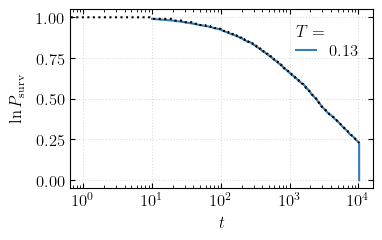

In [21]:
fig, ax = plt.subplots(1, 1, figsize = (4,2.6))
gammas1 = np.zeros((len(temperatureList), 2))
cls = cycle(allcolors[:len(temperatureList)])

for ii, tmp in enumerate(tmpList):
    temp, m2, sigmafld = get_model(*general, tmp)
    exp_params = [nLat, m2, temp]
    maxSim = (1000 if tmp == 0 else 2000 if tmp==1 else 3000 if tmp==2 else 2000)

    col = next(cls)
    ax.plot(decayTimes[ii]*dxList[ii], f_surv(decayTimes[ii], len(decayTimes[ii])), color=col, ls='-', label=r'${:.2f}$'.format(temp))
    ax.plot(t_l[ii], Psurv[ii], color='k', ls=':')

ax.set_ylabel(r'$\ln P_{\rm surv}$')
ax.set_xlabel(r'$t$')
ax.set_xscale('log')
beautify(ax, loc='best', times=-100, ttl=r'$T=$')
fig.tight_layout()
plt.show()

/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


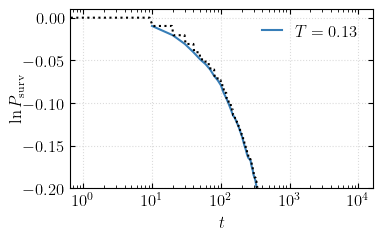

In [22]:
fig, ax = plt.subplots(1, 1, figsize = (4,2.6))
gammas1 = np.zeros((len(temperatureList), 2))
cls = cycle(allcolors[:len(temperatureList)])

for ii, tmp in enumerate(tmpList):
    temp, m2, sigmafld = get_model(*general, tmp)
    exp_params = [nLat, m2, temp]
    maxSim = (1000 if tmp == 0 else 2000 if tmp==1 else 3000 if tmp==2 else 2000)

    col = next(cls)
    ax.plot(decayTimes[ii]*dxList[ii], np.log(f_surv(decayTimes[ii], len(decayTimes[ii]))), color=col, ls='-', label=r'$T={:.2f}$'.format(temp))
    ax.plot(t_l[ii], np.log(Psurv[ii]), color='k', ls=':')

ax.set_ylabel(r'$\ln P_{\rm surv}$')
ax.set_xlabel(r'$t$')
ax.set_ylim(-log_P_threshold, 0.01)
ax.set_xscale('log')
beautify(ax, loc='best', times=-100)
#ax.ticklabel_format(axis='x', style='scientific', scilimits=[-1.,0.])
fig.tight_layout()
plt.show()

/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


IndexError: index 1 is out of bounds for axis 0 with size 1

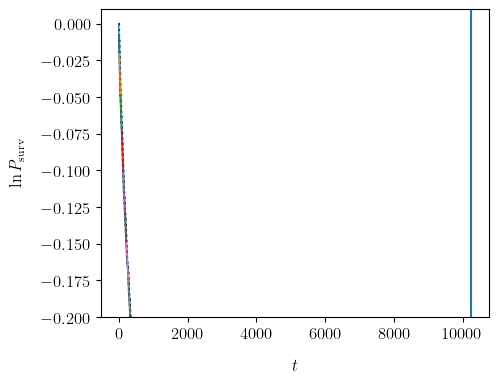

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (5,4))
gammas1 = np.zeros((len(temperatureList), 2))
cls = cycle(allcolors[:len(temperatureList)])

for ii, tmp in enumerate(tmpList):
    temp, m2, sigmafld = get_model(*general, tmp)
    exp_params = [nLat, m2, temp]
    maxSim = (1000 if tmp == 0 else 2000 if tmp==1 else 3000 if tmp==2 else 2000)

    col = next(cls)
    ax.plot(decayTimes[ii]*dxList[ii], np.log(f_surv(decayTimes[ii], len(decayTimes[ii]))), color=col, ls='-', label=r'$T={:.2f}$'.format(temp))
    ax.plot(t_l[ii], np.log(Psurv[ii]), color='k', ls=':')

    for jj in range(N_segments):
       # plt.axvline(time_end_points[ii][jj][0], ls=':', color='darkgray')

        ind = np.argmin(np.abs(t_l[ii] - time_end_points[ii][jj][0]))

        amp = np.log(Psurv[ii][ind])

        xs  = np.arange(time_end_points[ii][jj][0], time_end_points[ii][jj][1]+1)
        xs0 = xs - time_end_points[ii][jj][0]

        plt.plot(xs, amp - Gamma_t_list[ii][jj] * xs0, ls='-', lw=1)

ax.set_ylabel(r'$\ln P_{\rm surv}$')
ax.set_xlabel(r'$t$')
ax.set_ylim(-log_P_threshold, 0.01)
#ax.set_xlim(1, 2e4)
#ax.set_xscale('log')
plt.axvline(TimeOfSimList[0])
plt.axvline(TimeOfSimList[1])
beautify(ax, loc='best', times=-100)
#ax.ticklabel_format(axis='x', style='scientific', scilimits=[-1.,0.])
fig.tight_layout()
plt.show()

In [24]:
""" Extrapolate the tilt of the lines to t=0 """

def log_Gamma_fit(t, a, b):
    return a - b*t

log_Gamma_at_zero, slope, log_Gamma_at_zero_error = np.zeros((3, M))

for i in range(M):
    params, cov = curve_fit(log_Gamma_fit, time_points[i][1:], np.log(Gamma_t_list[i][1:]), sigma=Gamma_t_errors_list[i][1:]/Gamma_t_list[i][1:], absolute_sigma=True)

    log_Gamma_at_zero[i] = params[0]
    slope[i] = params[1]
    log_Gamma_at_zero_error[i] = np.sqrt(cov[0,0])


In [27]:
""" Fit: sphaleron energy """

# reference temperature
rf = 0
T0_inv = 1./TempList[rf]
print(T0_inv)

def log_Gamma_th(T_inv, Es):
    return - Es * (T_inv - T0_inv)

param, cov = curve_fit(log_Gamma_th, 1./TempList, log_Gamma_at_zero - log_Gamma_at_zero[rf], \
                       sigma = np.sqrt(log_Gamma_at_zero_error**2. + log_Gamma_at_zero_error[rf]**2.)/2., absolute_sigma=True)

Es = param[0]
Es_error = np.sqrt(cov[0,0])

chi2 = 0.
for i in range(M):
    a = log_Gamma_th(1./TempList[i], Es)
    b = log_Gamma_at_zero[i]-log_Gamma_at_zero[rf]
    c = np.sqrt(log_Gamma_at_zero_error[i]**2 + log_Gamma_at_zero_error[rf]**2)/2
    chi2 += ((a-b)/c)**2
chi2 /= M

print('energy:')
print(Es, Es_error, chi2)

7.692307692307692
energy:
1.0 inf 0.0


/home/dpirvu/.local/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [28]:
""" Fit: prefactor """

Es_th = 4./3.
T_middle = np.mean(TempList[:-1]); print(T_middle)
log_A_th = np.log(6. * lenLat / np.pi * np.sqrt(Es_th / 2. / np.pi / T_middle)); print(log_A_th)

def log_Gamma_th2(T_inv, log_A):
    return log_A - Es_th * T_inv + 0.5 * np.log(T_inv)

param, cov = curve_fit(log_Gamma_th2, 1./TempList, log_Gamma_at_zero, sigma=log_Gamma_at_zero_error, absolute_sigma=True)

log_A = param[0]
log_A_error = np.sqrt(cov[0,0])

chi2 = 0.
for i in range(M):
    a = log_Gamma_th2(1./TempList[i], log_A)
    b = log_Gamma_at_zero[i]
    c = log_Gamma_at_zero_error[i]
    chi2 += ((a-b)/c)**2.
chi2 /= M

print('log of Prefactor:')
print(round(log_A,3), round(log_A_error,3), round(chi2,3))
print('ratio:')
print(round(np.exp(log_A)/np.exp(log_A_th),3))
print(round(np.exp(log_A_error)/np.exp(log_A_th),3))
print(round(log_A - log_A_th,3))


nan
nan
log of Prefactor:
2.191 0.09 0.0
ratio:
nan
nan
nan


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[7.69230769] [-2.19111226] [0.08971512]


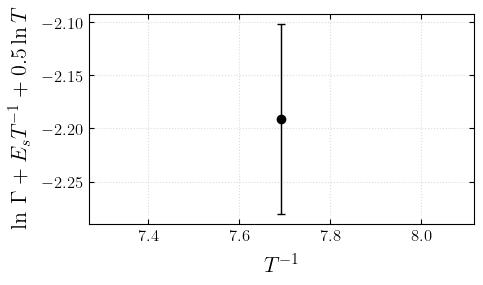

In [29]:
""" Plot Prefactor """

Tinv = np.linspace(1./TempList[0], 1./TempList[-1], 100)

fig, ax = plt.subplots(1, 1, figsize=(5,3))
ax.errorbar(1./TempList, log_Gamma_at_zero + Es_th/TempList + 0.5 * np.log(TempList) - np.log(lenLatList), log_Gamma_at_zero_error, color='k', fmt='o', elinewidth=1, capsize=3)
print(1./TempList, log_Gamma_at_zero + Es_th/TempList + 0.5 * np.log(TempList) - np.log(lenLatList), log_Gamma_at_zero_error)

ax.plot(Tinv, log_Gamma_th2(Tinv, log_A) + Es_th*Tinv - 0.5 * np.log(Tinv) - np.log(lenLat), color='k')

ax.fill_between(Tinv, log_Gamma_th2(Tinv, log_A-log_A_error) + Es_th*Tinv - 0.5 * np.log(Tinv) - np.log(lenLat), \
                      log_Gamma_th2(Tinv, log_A+log_A_error) + Es_th*Tinv - 0.5 * np.log(Tinv) - np.log(lenLat), color='k', alpha=0.2)

#ax.plot(1./T_middle, log_Gamma_th2(1./T_middle, log_A_th) + Es_th/T_middle + 0.5 * np.log(T_middle), color='r', marker='o')

plt.xlabel(r'$T^{-1}$', fontsize=16)
ax.set_ylabel(r'$\ln\: \Gamma + E_sT^{-1} + 0.5 \ln T$', fontsize=16)
beautify(ax, times=-100)
plt.tight_layout()
plt.savefig('./plots/pref.pdf')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


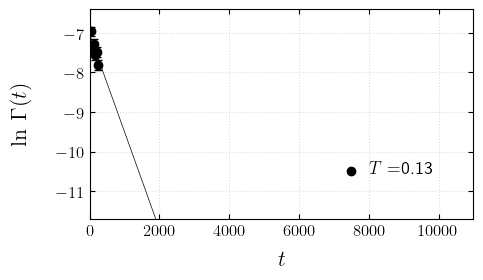

In [30]:
""" Plot the decay rate extrapolation lines """

fig, ax = plt.subplots(1, 1, figsize=(5,3))
clr = ['black', 'blue', 'red']
shp = ['o', 'v', 's']
j = 0
for i in range(len(tmpList)):
    ax.errorbar(time_points[i][1:-1], np.log(Gamma_t_list[i][1:-1]), Gamma_t_errors_list[i][1:-1]/Gamma_t_list[i][1:-1], color=clr[j], fmt=shp[j], elinewidth=1,capsize=3)
    ax.errorbar([7500],[-10.5+j*0.3],[0],color=clr[j], fmt=shp[j], elinewidth=1,capsize=3)
    plt.text(8000,-10.55+j*0.3,r'$T=$'+f'{TempList[i]}',fontsize=13)
    ax.plot(t_l[i],log_Gamma_fit(t_l[i],log_Gamma_at_zero[i],slope[i]),color=clr[j],linewidth=0.5)
    j += 1
plt.xlabel(r'$t$',fontsize=16)
plt.xlim((0,11000))
plt.ylim((-11.7,-6.4))
ax.set_ylabel(r'$\ln\:\Gamma(t)$',fontsize=16)
#plt.savefig('Gamma(t).pdf')
beautify(ax, times=-100)
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


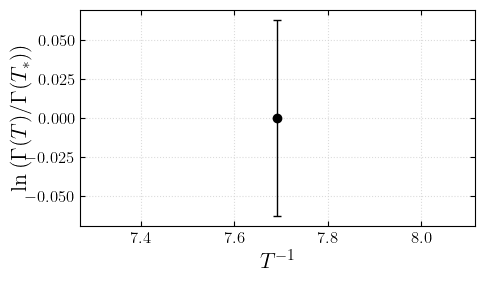

In [31]:
""" Plot the resulting fit """

Tinv = np.linspace(1./TempList[0], 1./TempList[-1], 100)
fig, ax = plt.subplots(1, 1, figsize=(5,3))
ax.plot(Tinv, log_Gamma_th(Tinv, Es), 'black', linewidth=1)

ax.plot(Tinv, log_Gamma_th2(Tinv, log_A_th)-log_Gamma_th2(1./TempList[rf], log_A_th), 'red', linestyle='dashed', linewidth=1)

plt.errorbar(1./TempList, log_Gamma_at_zero-log_Gamma_at_zero[rf], \
             np.sqrt(log_Gamma_at_zero_error**2 + log_Gamma_at_zero_error[rf]**2)/2, color='black', fmt='o', elinewidth=1, capsize=3)

plt.xlabel(r'$T^{-1}$',fontsize=16)
ax.set_ylabel(r'$\ln\: (\Gamma(T)/\Gamma(T_*))$',fontsize=16)
#plt.text(10.6,0.52,r'$E_s^{(exp)}=1.329\pm 0.087$',fontsize=14)
#plt.savefig('E_sph1.pdf')
beautify(ax, times=-80)
plt.tight_layout()
plt.show()